In [1]:
#| default_exp training

In [16]:
#|export
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from pathlib import Path
from torch import tensor,nn
import torch.nn.functional as F
import pdb

In [17]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

path_data = Path('data')
path_gz = path_data/'mnist.pkl.gz'
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train, y_train, x_valid, y_valid = map(tensor, [x_train, y_train, x_valid, y_valid])

## Initial setup

### Data

In [18]:
n,m = x_train.shape
c = y_train.max()+1
nh = 50

In [19]:
class Model(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        self.layers = [nn.Linear(n_in,nh), nn.ReLU(), nn.Linear(nh,n_out)]
        
    def __call__(self, x):
        for l in self.layers: x = l(x)
        return x

In [20]:
model = Model(m, nh, 10)
pred = model(x_train)
pred.shape

torch.Size([50000, 10])

In [21]:
pred

tensor([[-0.09, -0.21, -0.08,  ..., -0.03,  0.01,  0.06],
        [-0.07, -0.14, -0.14,  ...,  0.03,  0.04,  0.14],
        [-0.19, -0.04,  0.02,  ..., -0.01, -0.00,  0.02],
        ...,
        [-0.03, -0.22, -0.04,  ..., -0.01,  0.09,  0.14],
        [-0.10, -0.09, -0.05,  ..., -0.01,  0.02,  0.11],
        [-0.03, -0.25, -0.06,  ...,  0.00,  0.03,  0.14]], grad_fn=<AddmmBackward0>)

### Cross entropy loss

First, we will need to compute the softmax of our activations. This is defined by:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{e^{x_{0}} + e^{x_{1}} + \cdots + e^{x_{n-1}}}$$

or more concisely:

$$\hbox{softmax(x)}_{i} = \frac{e^{x_{i}}}{\sum\limits_{0 \leq j \lt n} e^{x_{j}}}$$ 

In practice, we will need the log of the softmax when we calculate the loss.7

FGS: sum(-1) -> sum over the last dimension. If shape is (i, j). j will be squezed. Meaning all rows will be all value
keepdim is the same as not droping the axis, meaning final shape will be (i, 1) insteaded of (i,)

In [22]:
import math

In [23]:
def log_softmax(x): return (x.exp()/(x.exp().sum(-1,keepdim=True))).log()

In [24]:
pred.exp().sum(1)[:, None]

tensor([[ 9.79],
        [ 9.97],
        [ 9.91],
        ...,
        [10.01],
        [ 9.80],
        [ 9.94]], grad_fn=<UnsqueezeBackward0>)

In [25]:
log_softmax(pred)

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<LogBackward0>)

Note that the formula 

$$\log \left ( \frac{a}{b} \right ) = \log(a) - \log(b)$$ 

gives a simplification when we compute the log softmax:

In [26]:
# ln(e^x) = x
def log_softmax(x): return x - x.exp().sum(-1,keepdim=True).log()

Then, there is a way to compute the log of the sum of exponentials in a more stable way, called the [LogSumExp trick](https://en.wikipedia.org/wiki/LogSumExp). The idea is to use the following formula:

$$\log \left ( \sum_{j=1}^{n} e^{x_{j}} \right ) = \log \left ( e^{a} \sum_{j=1}^{n} e^{x_{j}-a} \right ) = a + \log \left ( \sum_{j=1}^{n} e^{x_{j}-a} \right )$$

where a is the maximum of the $x_{j}$.

In [27]:
# this covers the denominator of log_softamx
def logsumexp(x):
    m = x.max(-1)[0]
    # pdb.set_trace()
    return m + (x-m[:,None]).exp().sum(-1).log()

This way, we will avoid an overflow when taking the exponential of a big activation. In PyTorch, this is already implemented for us. 

In [28]:
def log_softmax(x): return x - x.logsumexp(-1,keepdim=True)

In [29]:
pred.logsumexp(-1, keepdim=True).shape

torch.Size([50000, 1])

In [30]:
pred - logsumexp(pred)[:,None]

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<SubBackward0>)

In [31]:
test_close(logsumexp(pred), pred.logsumexp(-1))
sm_pred = log_softmax(pred)
sm_pred

tensor([[-2.37, -2.49, -2.36,  ..., -2.31, -2.28, -2.22],
        [-2.37, -2.44, -2.44,  ..., -2.27, -2.26, -2.16],
        [-2.48, -2.33, -2.28,  ..., -2.30, -2.30, -2.27],
        ...,
        [-2.33, -2.52, -2.34,  ..., -2.31, -2.21, -2.16],
        [-2.38, -2.38, -2.33,  ..., -2.29, -2.26, -2.17],
        [-2.33, -2.55, -2.36,  ..., -2.29, -2.27, -2.16]], grad_fn=<SubBackward0>)

The cross entropy loss for some target $x$ and some prediction $p(x)$ is given by:

$$ -\sum x\, \log p(x) $$

But since our $x$s are 1-hot encoded (actually, they're just the integer indices), this can be rewritten as $-\log(p_{i})$ where i is the index of the desired target.

This can be done using numpy-style [integer array indexing](https://docs.scipy.org/doc/numpy-1.13.0/reference/arrays.indexing.html#integer-array-indexing). Note that PyTorch supports all the tricks in the advanced indexing methods discussed in that link.

In [32]:
y_train[:3]

tensor([5, 0, 4])

In [33]:
sm_pred[0]

tensor([-2.37, -2.49, -2.36, -2.19, -2.32, -2.20, -2.32, -2.31, -2.28, -2.22], grad_fn=<SelectBackward0>)

In [34]:
# row 0, pred 5 ...
sm_pred[0,5],sm_pred[1,0],sm_pred[2,4]

(tensor(-2.20, grad_fn=<SelectBackward0>),
 tensor(-2.37, grad_fn=<SelectBackward0>),
 tensor(-2.36, grad_fn=<SelectBackward0>))

In [35]:
sm_pred[[0,1,2], y_train[:3]]

tensor([-2.20, -2.37, -2.36], grad_fn=<IndexBackward0>)

In [36]:
sm_pred.shape

torch.Size([50000, 10])

In [37]:
y_train.shape

torch.Size([50000])

In [38]:
-sm_pred[range(y_train.shape[0]), y_train].mean()

tensor(2.30, grad_fn=<NegBackward0>)

In [39]:
def nll(input, target): return -input[range(target.shape[0]), target].mean()

In [40]:
loss = nll(sm_pred, y_train)
loss

tensor(2.30, grad_fn=<NegBackward0>)

Then use PyTorch's implementation.

In [41]:
test_close(F.nll_loss(F.log_softmax(pred, -1), y_train), loss, 1e-3)

In PyTorch, `F.log_softmax` and `F.nll_loss` are combined in one optimized function, `F.cross_entropy`.

In [42]:
test_close(F.cross_entropy(pred, y_train), loss, 1e-3)

In [43]:
## Homework implement log_sofmax, nll_loss and cross_entropy loss yorself

## Basic training loop

Basically the training loop repeats over the following steps:
- get the output of the model on a batch of inputs
- compare the output to the labels we have and compute a loss
- calculate the gradients of the loss with respect to every parameter of the model
- update said parameters with those gradients to make them a little bit better

In [44]:
loss_func = F.cross_entropy

In [45]:
bs=64                  # batch size

xb = x_train[0:bs]     # a mini-batch from x
preds = model(xb)      # predictions
preds[0], preds.shape

(tensor([-0.09, -0.21, -0.08,  0.10, -0.04,  0.08, -0.04, -0.03,  0.01,  0.06], grad_fn=<SelectBackward0>),
 torch.Size([64, 10]))

In [46]:
yb = y_train[0:bs]
yb

tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
        3, 9, 8, 5, 9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0])

In [47]:
loss_func(preds, yb)

tensor(2.30, grad_fn=<NllLossBackward0>)

In [48]:
(preds.argmax(dim=1) == yb).float()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [49]:
#|export
def accuracy(out, yb): return (out.argmax(dim=1)==yb).float().mean()

In [50]:
accuracy(preds, yb)

tensor(0.09)

In [51]:
lr = 0.5   # learning rate
epochs = 3 # how many epochs to train for

In [52]:
#|export
def report(loss, preds, yb): print(f'{loss:.2f}, {accuracy(preds, yb):.2f}')

In [53]:
xb,yb = x_train[:bs],y_train[:bs]
preds = model(xb)
report(loss_func(preds, yb), preds, yb)

2.30, 0.09


In [54]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb,yb = x_train[s],y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        with torch.no_grad():
            for l in model.layers:
                if hasattr(l, 'weight'): # update the weights
                    l.weight -= l.weight.grad * lr
                    l.bias   -= l.bias.grad   * lr
                    l.weight.grad.zero_()
                    l.bias  .grad.zero_() # _means in place
    report(loss, preds, yb)

0.19, 0.94
0.05, 1.00
0.03, 1.00


## Using parameters and optim

FGS: END of L13

### Parameters

In [55]:
m1 = nn.Module()
# FGS: Normally not used this way
m1.foo = nn.Linear(3,4)
m1

Module(
  (foo): Linear(in_features=3, out_features=4, bias=True)
)

In [56]:
# it auto tracks all children inside
list(m1.named_children())

[('foo', Linear(in_features=3, out_features=4, bias=True))]

In [57]:
m1.named_children()

<generator object Module.named_children at 0x7f4e6b9a0e40>

In [58]:
list(m1.parameters())

[Parameter containing:
 tensor([[ 0.57,  0.43, -0.30],
         [ 0.13, -0.32, -0.24],
         [ 0.51,  0.04,  0.22],
         [ 0.13, -0.17, -0.24]], requires_grad=True),
 Parameter containing:
 tensor([-0.01, -0.51, -0.39,  0.56], requires_grad=True)]

In [59]:
# FGS: example of a custom pytorch module
class MLP(nn.Module):
    def __init__(self, n_in, nh, n_out):
        super().__init__()
        # same as the foo assignment prior
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)
        self.relu = nn.ReLU()
        
    def forward(self, x): return self.l2(self.relu(self.l1(x)))

In [60]:
m

784

In [61]:
nh # number hidden

50

In [62]:
model = MLP(m, nh, 10)
model.l1

Linear(in_features=784, out_features=50, bias=True)

In [63]:
model

MLP(
  (l1): Linear(in_features=784, out_features=50, bias=True)
  (l2): Linear(in_features=50, out_features=10, bias=True)
  (relu): ReLU()
)

In [64]:
for name,l in model.named_children(): print(f"{name}: {l}")

l1: Linear(in_features=784, out_features=50, bias=True)
l2: Linear(in_features=50, out_features=10, bias=True)
relu: ReLU()


In [65]:
for p in model.parameters(): print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


In [66]:
def fit():
    for epoch in range(epochs):
        for i in range(0, n, bs):
            s = slice(i, min(n,i+bs))
            xb,yb = x_train[s],y_train[s]
            preds = model(xb) 
            loss = loss_func(preds, yb)
            loss.backward()
            with torch.no_grad():
                for p in model.parameters(): p -= p.grad * lr
                model.zero_grad()
        report(loss, preds, yb)

In [67]:
fit()

0.41, 0.94
0.10, 1.00
0.05, 1.00


Behind the scenes, PyTorch overrides the `__setattr__` function in `nn.Module` so that the submodules you define are properly registered as parameters of the model.

In [68]:
#FGS: our own nn.module
class MyModule:
    def __init__(self, n_in, nh, n_out):
        self._modules = {}
        self.l1 = nn.Linear(n_in,nh)
        self.l2 = nn.Linear(nh,n_out)

    def __setattr__(self,k,v):
        if not k.startswith("_"): self._modules[k] = v
        super().__setattr__(k,v) # Super is calling the object class so __setattr__ is called

    def __repr__(self): return f'{self._modules}'
    
    def parameters(self):
        for l in self._modules.values(): yield from l.parameters()

In [69]:
mdl = MyModule(m,nh,10)
mdl

{'l1': Linear(in_features=784, out_features=50, bias=True), 'l2': Linear(in_features=50, out_features=10, bias=True)}

In [70]:
for p in mdl.parameters(): print(p.shape)

torch.Size([50, 784])
torch.Size([50])
torch.Size([10, 50])
torch.Size([10])


### Registering modules

In [71]:
from functools import reduce

We can use the original `layers` approach, but we have to register the modules.

In [72]:
layers = [nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10)]

In [73]:
class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = layers
        for i,l in enumerate(self.layers): self.add_module(f'layer_{i}', l)

    def forward(self, x): return reduce(lambda val,layer: layer(val), self.layers, x)

In [74]:
model = Model(layers)
model

Model(
  (layer_0): Linear(in_features=784, out_features=50, bias=True)
  (layer_1): ReLU()
  (layer_2): Linear(in_features=50, out_features=10, bias=True)
)

In [75]:
model(xb).shape

torch.Size([16, 10])

### nn.ModuleList

`nn.ModuleList` does this for us.

In [76]:
class SequentialModel(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers) # same as the enumerate code aboe
        
    def forward(self, x):
        for l in self.layers: x = l(x)
        return x

In [77]:
model = SequentialModel(layers)
model

SequentialModel(
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [78]:
fit()

0.17, 0.94
0.11, 1.00
0.03, 1.00


### nn.Sequential

`nn.Sequential` is a convenient class which does the same as the above:

In [79]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [80]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.19, 0.94
0.14, 0.94
0.09, 0.94


(tensor(0.01, grad_fn=<NllLossBackward0>), tensor(1.))

In [81]:
model

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=10, bias=True)
)

### optim

In [82]:
class Optimizer():
    def __init__(self, params, lr=0.5): self.params,self.lr=list(params),lr

    def step(self):
        with torch.no_grad():
            for p in self.params: p -= p.grad * self.lr

    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

In [83]:
model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))

In [84]:
opt = Optimizer(model.parameters())

In [85]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        xb,yb = x_train[s],y_train[s]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.16, 0.94
0.15, 0.94
0.08, 1.00


PyTorch already provides this exact functionality in `optim.SGD` (it also handles stuff like momentum, which we'll look at later)

In [86]:
from torch import optim

In [87]:
def get_model():
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,10))
    return model, optim.SGD(model.parameters(), lr=lr)

In [88]:
model,opt = get_model()
loss_func(model(xb), yb)

tensor(2.32, grad_fn=<NllLossBackward0>)

In [89]:
x_train[slice(0, 64)].shape

torch.Size([64, 784])

In [90]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        s = slice(i, min(n,i+bs))
        # print(s)
        xb,yb = x_train[s],y_train[s] # still looks clunky
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.23, 0.94
0.13, 1.00
0.14, 1.00


## Dataset and DataLoader

### Dataset

It's clunky to iterate through minibatches of x and y values separately:

```python
    xb = x_train[s]
    yb = y_train[s]
```

Instead, let's do these two steps together, by introducing a `Dataset` class:

```python
    xb,yb = train_ds[s]
```

In [91]:
#|export
class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i],self.y[i]

In [92]:
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
assert len(train_ds)==len(x_train)
assert len(valid_ds)==len(x_valid)

In [93]:
xb,yb = train_ds[0:5]
assert xb.shape==(5,28*28)
assert yb.shape==(5,)
xb,yb

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4, 1, 9]))

In [94]:
model,opt = get_model()

In [95]:
for epoch in range(epochs):
    for i in range(0, n, bs):
        xb,yb = train_ds[i:min(n,i+bs)]
        preds = model(xb)
        loss = loss_func(preds, yb)
        loss.backward()
        opt.step()
        opt.zero_grad()
    report(loss, preds, yb)

0.27, 0.94
0.13, 0.94
0.20, 0.94


### DataLoader

Previously, our loop iterated over batches (xb, yb) like this:

```python
for i in range(0, n, bs):
    xb,yb = train_ds[i:min(n,i+bs)]
    ...
```

Let's make our loop much cleaner, using a data loader:

```python
for xb,yb in train_dl:
    ...
```

In [96]:
class DataLoader():
    def __init__(self, ds, bs): self.ds,self.bs = ds,bs
    def __iter__(self):
        for i in range(0, len(self.ds), self.bs): yield self.ds[i:i+self.bs]

In [97]:
train_dl = DataLoader(train_ds, bs)
valid_dl = DataLoader(valid_ds, bs)

In [98]:
xb,yb = next(iter(valid_dl))
xb.shape, yb.shape

(torch.Size([64, 784]), torch.Size([64]))

In [99]:
yb

tensor([3, 8, 6, 9, 6, 4, 5, 3, 8, 4, 5, 2, 3, 8, 4, 8, 1, 5, 0, 5, 9, 7, 4, 1, 0, 3, 0, 6, 2, 9, 9, 4, 1, 3, 6, 8, 0, 7, 7, 6, 8, 9, 0, 3,
        8, 3, 7, 7, 8, 4, 4, 1, 2, 9, 8, 1, 1, 0, 6, 6, 5, 0, 1, 1])

tensor(3)

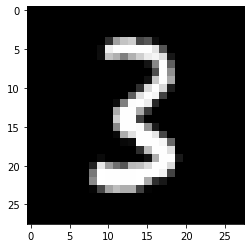

In [100]:
plt.imshow(xb[0].view(28,28))
yb[0]

In [101]:
model,opt = get_model()

In [102]:
# FGS: its getting smaller ... 
def fit():
    for epoch in range(epochs):
        for xb,yb in train_dl:
            preds = model(xb)
            loss = loss_func(preds, yb)
            loss.backward()
            opt.step()
            opt.zero_grad()
        report(loss, preds, yb)

In [103]:
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.32, 0.94
0.22, 0.94
0.18, 0.94


(tensor(0.05, grad_fn=<NllLossBackward0>), tensor(0.98))

### Random sampling

We want our training set to be in a random order, and that order should differ each iteration. But the validation set shouldn't be randomized.

In [114]:
import random

In [115]:
class Sampler():
    def __init__(self, ds, shuffle=False): self.n,self.shuffle = len(ds),shuffle
    def __iter__(self):
        res = list(range(self.n))
        if self.shuffle: random.shuffle(res)
        return iter(res)

In [116]:
from itertools import islice

In [117]:
ss = Sampler(train_ds) # shuffle False

In [118]:
it = iter(ss)
for o in range(5): print(next(it))

0
1
2
3
4


In [119]:
list(islice(ss, 5))

[0, 1, 2, 3, 4]

In [120]:
ss = Sampler(train_ds, shuffle=True)
list(islice(ss, 10))

[10312, 43531, 3842, 7754, 29782, 6229, 10749, 8882, 49109, 19736]

In [121]:
import fastcore.all as fc

In [122]:
class BatchSampler():
    def __init__(self, sampler, bs, drop_last=False): fc.store_attr()
    def __iter__(self): yield from fc.chunked(iter(self.sampler), self.bs, drop_last=self.drop_last)

In [123]:
batchs = BatchSampler(ss, 4)
list(islice(batchs, 5))

[[4403, 20791, 15432, 4388],
 [18432, 19228, 37832, 23608],
 [6019, 9235, 1812, 32839],
 [5156, 1844, 10652, 39666],
 [13112, 30744, 18026, 3178]]

In [124]:
def collate(b):
    xs,ys = zip(*b)
    return torch.stack(xs),torch.stack(ys)

In [125]:
class DataLoader():
    def __init__(self, ds, batchs, collate_fn=collate): fc.store_attr() # shortcut fastcore to store init attrs
    def __iter__(self): yield from (self.collate_fn(self.ds[i] for i in b) for b in self.batchs)

In [126]:
train_samp = BatchSampler(Sampler(train_ds, shuffle=True ), bs)
valid_samp = BatchSampler(Sampler(valid_ds, shuffle=False), bs)

In [127]:
# what is collate doing???
o = next(iter(train_samp))

In [128]:
o[:5], len(o)

([20648, 15998, 38307, 17235, 34379], 64)

In [129]:
# 64 examples x,y from train_ds
p = [train_ds[i] for i in o]

In [131]:
len(p) # bs size
p[0][0].shape, p[0][1]# first xs, ys pair of the batch

(torch.Size([784]), tensor(8))

In [117]:
xs,ys = zip(*p) # unpack all into xs and ys but each are individual tensors

In [118]:
len(xs), len(ys)

(64, 64)

In [119]:
# one tensor
torch.stack(xs).shape, torch.stack(ys).shape

(torch.Size([64, 784]), torch.Size([64]))

In [120]:
train_dl = DataLoader(train_ds, batchs=train_samp)
valid_dl = DataLoader(valid_ds, batchs=valid_samp)

tensor(3)

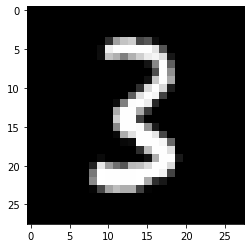

In [121]:
xb,yb = next(iter(valid_dl))
plt.imshow(xb[0].view(28,28))
yb[0]

In [123]:
xb.shape,yb.shape

(torch.Size([64, 784]), torch.Size([64]))

In [124]:
model,opt = get_model()

In [125]:
fit()

0.06, 0.94
0.09, 0.94
0.00, 1.00


### Multiprocessing DataLoader

Pytorch data loader uses this for parallel processing

In [126]:
import torch.multiprocessing as mp
from fastcore.basics import store_attr

In [127]:
train_ds[[3,6,8,1]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 1, 1, 0]))

In [116]:
# identical
train_ds.__getitem__([3,6,8,1])

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([1, 1, 1, 0]))

In [128]:
# map takes a sequence and calls a function in every element
for o in map(train_ds.__getitem__, ([3,6],[8,1])): print(o)

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 1]))
(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), tensor([1, 0]))


In [129]:
# voila a multiprocessing dataloader
class DataLoader():
    def __init__(self, ds, batchs, n_workers=1, collate_fn=collate): fc.store_attr()
    def __iter__(self):
        with mp.Pool(self.n_workers) as ex: yield from ex.map(self.ds.__getitem__, iter(self.batchs))

In [120]:
train_dl = DataLoader(train_ds, batchs=train_samp, n_workers=2)
it = iter(train_dl)

In [133]:
# xb,yb = next(it)
# xb.shape,yb.shape

### PyTorch DataLoader

In [132]:
#|export
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler, BatchSampler

In [157]:
len(list(iter(RandomSampler(train_ds))))

50000

In [150]:
train_samp = BatchSampler(RandomSampler(train_ds),     bs, drop_last=False)
valid_samp = BatchSampler(SequentialSampler(valid_ds), bs, drop_last=False)

In [134]:
train_dl = DataLoader(train_ds, batch_sampler=train_samp, collate_fn=collate)
valid_dl = DataLoader(valid_ds, batch_sampler=valid_samp, collate_fn=collate)

In [135]:
model,opt = get_model()
fit()
loss_func(model(xb), yb), accuracy(model(xb), yb)

0.10, 1.00
0.13, 0.94
0.01, 1.00


(tensor(0.04, grad_fn=<NllLossBackward0>), tensor(1.))

PyTorch can auto-generate the BatchSampler for us:

In [136]:
train_dl = DataLoader(train_ds, bs, sampler=RandomSampler(train_ds), collate_fn=collate)
valid_dl = DataLoader(valid_ds, bs, sampler=SequentialSampler(valid_ds), collate_fn=collate)

PyTorch can also generate the Sequential/RandomSamplers too:

In [137]:
train_dl = DataLoader(train_ds, bs, shuffle=True, drop_last=True, num_workers=2)
valid_dl = DataLoader(valid_ds, bs, shuffle=False, num_workers=2)

In [142]:
next(iter(train_dl))

[tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([3, 4, 2, 1, 8, 8, 4, 9, 4, 0, 5, 8, 2, 6, 1, 5, 4, 7, 2, 4, 6, 3, 8, 5, 1, 4, 7, 2, 9, 1, 4, 2, 8, 5, 5, 8, 5, 7, 8, 2, 2, 3, 7, 1,
         7, 2, 3, 2, 2, 8, 8, 4, 0, 3, 3, 7, 0, 3, 4, 8, 1, 9, 2, 5])]

In [140]:
model,opt = get_model()
fit()

loss_func(model(xb), yb), accuracy(model(xb), yb)

0.12, 0.95
0.18, 0.92
0.08, 0.98


(tensor(0.05, grad_fn=<NllLossBackward0>), tensor(0.98))

Our dataset actually already knows how to sample a batch of indices all at once:

In [141]:
train_ds[[4,6,7]]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([9, 1, 3]))

...that means that we can actually skip the batch_sampler and collate_fn entirely:

In [142]:
train_dl = DataLoader(train_ds, sampler=train_samp)
valid_dl = DataLoader(valid_ds, sampler=valid_samp)

In [143]:
xb,yb = next(iter(train_dl))
xb.shape,yb.shape

(torch.Size([1, 64, 784]), torch.Size([1, 64]))

You **always** should also have a [validation set](http://www.fast.ai/2017/11/13/validation-sets/), in order to identify if you are overfitting.

We will calculate and print the validation loss at the end of each epoch.

(Note that we always call `model.train()` before training, and `model.eval()` before inference, because these are used by layers such as `nn.BatchNorm2d` and `nn.Dropout` to ensure appropriate behaviour for these different phases.)

In [144]:
#|export
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb,yb in train_dl:
            loss = loss_func(model(xb), yb)
            loss.backward()
            opt.step()
            opt.zero_grad()

        model.eval()
        with torch.no_grad():
            tot_loss,tot_acc,count = 0.,0.,0
            for xb,yb in valid_dl:
                pred = model(xb)
                n = len(xb)
                count += n
                tot_loss += loss_func(pred,yb).item()*n
                tot_acc  += accuracy (pred,yb).item()*n
        print(epoch, tot_loss/count, tot_acc/count)
    return tot_loss/count, tot_acc/count

In [145]:
#|export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
            DataLoader(valid_ds, batch_size=bs*2, **kwargs))

Now, our whole process of obtaining the data loaders and fitting the model can be run in 3 lines of code:

In [146]:
train_dl,valid_dl = get_dls(train_ds, valid_ds, bs)
model,opt = get_model()

In [147]:
%time loss,acc = fit(5, model, loss_func, opt, train_dl, valid_dl)

0 0.16582908966243268 0.9529
1 0.1281229511067271 0.961
2 0.3598817442178726 0.8994
3 0.10627636167220772 0.9688
4 0.11368296324238181 0.9663
CPU times: user 2min 14s, sys: 494 ms, total: 2min 15s
Wall time: 23.9 s


## Export -

In [ ]:
import nbdev; nbdev.nbdev_export()